In [31]:
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import windows, spectrogram
import pickle
import pywt
import pywt.data
from sklearn.decomposition import PCA, FastICA
from PyEMD import EMD

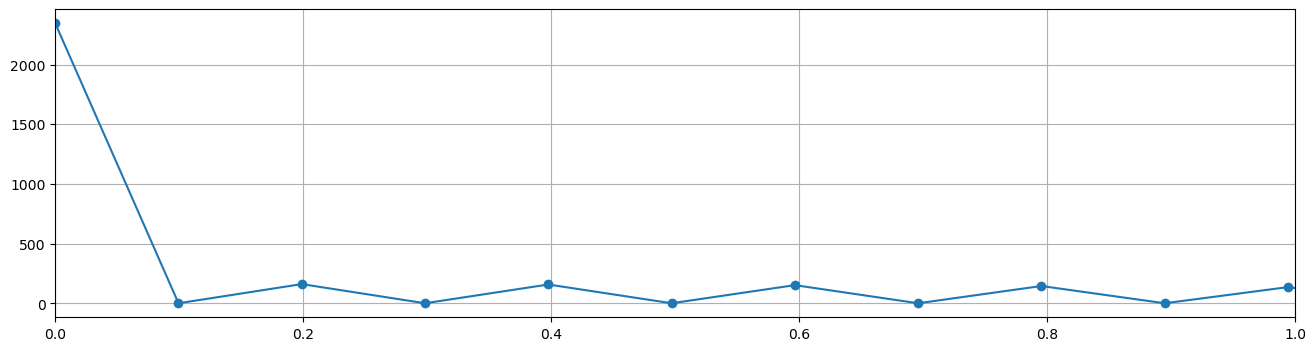

In [32]:
npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/LERFUJI_2024-10-21_08-08-53.npz',allow_pickle=True)
X_sum=npz_kw['X_sum']
for i in range(2560):
    if np.max(X_sum[i:i+50])<500:
        if X_sum[i+70]>500:
            start=i+70
            break

fillpattern=[]
for i in range(5120):
    if X_sum[start+i]>2000:
        fillpattern.append(1)
    else:
        fillpattern.append(0)

fillpattern=np.array(fillpattern)

fft_result = np.fft.fft(fillpattern)
fft_freqs = np.fft.fftfreq(len(fillpattern),d=1/509)
# 正の周波数部分のみ抽出
positive_freqs = fft_freqs[:len(fft_freqs)//2]
positive_fft = np.abs(fft_result[:len(fft_result)//2])

plt.figure(figsize=(16,4))
plt.plot(positive_freqs,positive_fft,'o-')
plt.grid()
plt.xlim(0,1)
plt.show()


# Abort

In [2]:
os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/')

['LERFUJI_2024-10-27_15-59-34.npz',
 'LERFUJI_2024-10-22_06-38-26.npz',
 'LERFUJI_2024-10-19_01-22-42.npz',
 'LERFUJI_2024-10-30_06-56-57.npz',
 'LERFUJI_2024-10-25_07-16-13.npz',
 'LERFUJI_2024-10-28_21-34-21.npz',
 'LERFUJI_2024-10-17_01-05-01.npz',
 'LERFUJI_2024-10-29_12-25-14.npz',
 'LERFUJI_2024-10-22_15-14-57.npz',
 'LERFUJI_2024-10-28_22-58-10.npz',
 'LERFUJI_2024-10-30_00-36-22.npz',
 'LERFUJI_2024-10-10_22-11-36.npz',
 'LERFUJI_2024-10-29_21-24-26.npz',
 'LERFUJI_2024-10-22_03-20-25.npz',
 'LERFUJI_2024-10-21_22-10-13.npz',
 'LERFUJI_2024-10-15_11-30-38.npz',
 'LERFUJI_2024-10-25_03-22-58.npz',
 'LERFUJI_2024-10-25_07-05-05.npz',
 'LERFUJI_2024-11-03_04-36-10.npz',
 'LERFUJI_2024-10-25_11-52-42.npz',
 'LERFUJI_2024-10-10_21-29-54.npz',
 'LERFUJI_2024-10-21_21-15-49.npz',
 'LERFUJI_2024-10-21_07-54-25.npz',
 'LERFUJI_2024-10-25_06-45-15.npz',
 'LERFUJI_2024-10-25_06-30-05.npz',
 'LERFUJI_2024-11-04_10-24-53.npz',
 'LERFUJI_2024-10-22_11-57-54.npz',
 'LERFUJI_2024-10-20_11-00-2

In [152]:
def make_mastdplot(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']
    X_pos=npz_kw['X_Pos']
    X_ma=npz_kw['X_MA']
    X_std=npz_kw['X_STD']
    #X_valid=npz_kw['X_valid']
    Y_pos=npz_kw['Y_Pos']
    Y_ma=npz_kw['Y_MA']
    Y_std=npz_kw['Y_STD']
    #Y_valid=npz_kw['Y_valid']
    #iv=npz_kw['Injection_Veto']
    abortflag=npz_kw['AbortFlag']


    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        X_std=np.zeros(len(X_pos))
        X_delta=np.zeros(len(X_sum))
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        X_sum=np.zeros(len(X_delta))
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))
    timesteps=np.arange(len(X_pos))/254.5
    timesteps=timesteps-timesteps[-1]

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result_x'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_x'] = df['result_x'] - df['result_x'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_x'] = np.where(abs(df['result_diff_x']) > 0.2, 0, df['result_diff_x'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=2)

    df['result_y'] = np.where(df['X_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_y'] = df['result_y'] - df['result_y'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_y'] = np.where(abs(df['result_diff_y']) > 0.2, 0, df['result_diff_y'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=2)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除



    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return np.nan
    tbtdata_111_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values

    
    #------------------
    signal=tbtdata_111_x
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_fft = np.abs(fft_result[:len(fft_result)//2])
    positive_phase = np.angle(fft_result[:len(fft_result)//2])
    signal=tbtdata_111_y
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqsy = fft_freqs[:len(fft_freqs)//2]
    positive_ffty = np.abs(fft_result[:len(fft_result)//2])
    positive_phasey = np.angle(fft_result[:len(fft_result)//2])
    #-------------------



    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,5))
    ax1.set_title(f'{filename}')
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.scatter(timeaxis,tbtdata_111_x,c='red',s=1)
    ax1.set_ylim(-0.2,0.2)
    ax1.grid()
    ax1.set_ylabel('X position (mm)')
    ax2.scatter(timeaxis,tbtdata_111_y,c='red',s=1)
    ax2.set_ylim(-0.2,0.2)
    ax2.grid()
    ax2.set_ylabel('Y position (mm)')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_pos.png',dpi=100)
    plt.close()
    

    ######################################

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqs[:1000], positive_fft[:1000])
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.yscale('log')
    #plt.xlim(0,1)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_fftx.png',dpi=100)
    plt.close()

    ######################################

    """
    signal=tbtdata_111_x
    sampling_frequency = 509e6  # 509 MHz
    duration = len(signal)/sampling_frequency  # データの長さ（1ミリ秒）
    scales = np.arange(1000, 1100)  # スケール範囲を調整
    coefficients, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=1/sampling_frequency)
    # ヒートマップをプロット
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), extent=[0, duration, frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
    plt.colorbar(label="Amplitude")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Wavelet Transform (CWT) - Focused on Low Frequencies")
    #plt.ylim(0, 100e3)  # 0から100 kHzの範囲を表示
    plt.show()
    """

    

    """
    signal=tbtdata_111_x[-5120*50:]
    t=np.arange(len(signal))/509
    emd = EMD()
    imfs = emd(signal)
    
    # 結果をプロット
    plt.figure(figsize=(10, 16))
    plt.subplot(len(imfs) + 1, 1, 1)
    plt.plot(t, signal, 'r')
    plt.title("Original Signal")
    
    for i, imf in enumerate(imfs):
        plt.subplot(len(imfs) + 1, 1, i + 2)
        plt.plot(t, imf, 'g')
        plt.title(f"IMF {i + 1}")
    
    plt.tight_layout()
    plt.show()
    """

    """
    tbt_x=tbtdata_111_x.reshape([turn,5120])
    tbt_x = tbt_x[:, tbt_x[0] != 0]
    tbt_x -= np.mean(tbt_x, axis=0)
    tbt_x /= np.std(tbt_x, axis=0)
    n_components=5
    pca = PCA(n_components=n_components)
    #ica = FastICA(n_components=n_components, random_state=0,max_iter=1000)
    #principal_components = ica.fit_transform(tbt_x)
    principal_components = pca.fit_transform(tbt_x)
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 20))
    for i, component in enumerate(principal_components.T):
        plt.subplot(len(principal_components.T), 1, i + 1)
        plt.plot(component)
        plt.title(f"Principal Component {i+1}")
    plt.tight_layout()
    plt.savefig(f'SBL_picture/{filename[8:-4]}_pcax_waveform.png',dpi=100)
    plt.close()

    
    # 結果のプロット
    plt.figure(figsize=(12, 8))
    # 主成分ごとの分散割合をプロット
    plt.subplot(2, 1, 1)
    plt.bar(range(1, n_components + 1), explained_variance * 100)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.title('Variance Explained by Each Principal Component')
    # 各主成分の波形をプロット
    plt.subplot(2, 1, 2)
    for i in range(n_components):
        plt.plot(principal_components[:, i], label=f'PC{i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Principal Components (Vibration Modes)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'SBL_picture/{filename[8:-4]}_pcax.png',dpi=100)
    plt.close()
    """
    
    """
    N2=len(principal_components)//2
    N3=N2-len(principal_components)
    t = np.arange(N3,N2)
    for i in range(n_components):
        split = principal_components.T[i]
        # omegaの範囲を指定
        omega_values =np.linspace(0, 3.14, 1000)
        integral_results = []
        # omegaの値を少しずつ変えて数値積分を実行
        for omega in omega_values:
            integrand = split * np.exp(-1j * omega * t) * (1 + np.cos(np.pi*t/N2))
            integral = np.trapz(integrand, t)  # トラペゾイド則で数値積分
            integral_results.append(integral/2/N2)
        
        plt.figure(figsize=(10,6))
        plt.plot(omega_values/2/np.pi, np.abs(integral_results))
        plt.savefig(f'SBL_picture/{filename[8:-4]}_naffx_{i}.png',dpi=100)
        plt.close()
    """
    """
    tbt_y=tbtdata_111_y.reshape([turn,5120])
    tbt_y = tbt_y[:, tbt_y[0] != 0]
    tbt_y -= np.mean(tbt_y, axis=0)
    tbt_y /= np.std(tbt_y, axis=0)
    pca = PCA(n_components=n_components)
    #ica = FastICA(n_components=n_components, random_state=0,max_iter=1000)
    #principal_components = ica.fit_transform(tbt_y)
    principal_components = pca.fit_transform(tbt_y)
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 20))
    for i, component in enumerate(principal_components.T):
        plt.subplot(len(principal_components.T), 1, i + 1)
        plt.plot(component)
        plt.title(f"Principal Component {i+1}")
    plt.tight_layout()
    plt.savefig(f'SBL_picture/{filename[8:-4]}_pcay_waveform.png',dpi=100)
    plt.close()

    
    # 結果のプロット
    plt.figure(figsize=(12, 8))
    # 主成分ごとの分散割合をプロット
    plt.subplot(2, 1, 1)
    plt.bar(range(1, n_components + 1), explained_variance * 100)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.title('Variance Explained by Each Principal Component')
    # 各主成分の波形をプロット
    plt.subplot(2, 1, 2)
    for i in range(n_components):
        plt.plot(principal_components[:, i], label=f'PC{i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Principal Components (Vibration Modes)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'SBL_picture/{filename[8:-4]}_pcay.png',dpi=100)
    plt.close()
    """
    
    """
    N2=len(principal_components)//2
    N3=N2-len(principal_components)
    t = np.arange(N3,N2)
    for i in range(n_components):
        split = principal_components.T[i]
        # omegaの範囲を指定
        omega_values =np.linspace(0, 3.14, 1000)
        integral_results = []
        # omegaの値を少しずつ変えて数値積分を実行
        for omega in omega_values:
            integrand = split * np.exp(-1j * omega * t) * (1 + np.cos(np.pi*t/N2))
            integral = np.trapz(integrand, t)  # トラペゾイド則で数値積分
            integral_results.append(integral/2/N2)
        
        plt.figure(figsize=(10,6))
        plt.plot(omega_values/2/np.pi, np.abs(integral_results))
        plt.savefig(f'SBL_picture/{filename[8:-4]}_naffy_{i}.png',dpi=100)
        plt.close()
    """


    """
   # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signal
    x = np.arange(len(signal))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]#* window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)


    
    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Xpos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,50)
    # プロット表示
    plt.savefig(f'SBL_picture/{filename[8:-4]}_fft3Dx.png',dpi=100)
    plt.close()
    

    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')

    #plt.ylim(240,254)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_fftheatmapx.png',dpi=100)
    plt.close()

    plt.figure(figsize=(16, 6))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')
    plt.ylim(254,244)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_fftheatmapx_expanded.png',dpi=100)
    plt.close()

    time_axis=window_times-window_times[-1]-10
    spectrum=fft_results.T[2508]
    plt.figure(figsize=(14,4))
    plt.plot(time_axis,spectrum,'o-')
    plt.ylim(0,20)
    plt.grid()
    plt.xlabel('Time (us)')
    plt.savefig(f'abort_picture/{filename[8:-4]}_amplitude_suii.png',dpi=100)
    plt.close()
    """


   

    ######################################3

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqsy[:1000], positive_ffty[:1000])
    plt.title('FFT of Ypos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.yscale('log')
    #plt.xlim(0,1)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_ffty.png',dpi=100)
    plt.close()
    

    """
    # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signaly
    x = np.arange(len(signaly))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]# * window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)

    
    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Ypos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,10)
    # プロット表示
    plt.savefig(f'SBL_picture/{filename[8:-4]}_fft3Dy.png',dpi=100)
    plt.close()
    
    
    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Ypos')

    plt.savefig(f'SBL_picture/{filename[8:-4]}_fftheatmapy.png',dpi=100)
    plt.close()
    """

    
    
    return positive_fft[:1000],positive_ffty[:1000],positive_phase[:1000],positive_phasey[:1000]

In [121]:
make_mastdplot('LERFUJI_2024-11-03_17-35-45.npz')

KeyboardInterrupt: 

In [153]:
x_fft=[]
y_fft=[]
x_phase=[]
y_phase=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'):
    print(i)
    a,b,c,d=make_mastdplot(i)
    x_fft.append(a)
    y_fft.append(b)
    x_phase.append(c)
    y_phase.append(d)

LERFUJI_2024-10-27_02-02-02.npz
LERFUJI_2024-10-20_13-51-29.npz
LERFUJI_2024-11-02_16-48-53.npz
LERFUJI_2024-10-21_08-08-53.npz
LERFUJI_2024-10-29_23-49-03.npz
LERFUJI_2024-10-28_02-30-07.npz
LERFUJI_2024-11-01_04-31-16.npz
LERFUJI_2024-10-27_06-17-55.npz
LERFUJI_2024-10-27_23-44-12.npz
LERFUJI_2024-11-04_04-14-19.npz
LERFUJI_2024-10-30_02-30-10.npz
LERFUJI_2024-10-22_09-20-05.npz
LERFUJI_2024-10-15_23-43-13.npz
LERFUJI_2024-10-15_20-22-59.npz
LERFUJI_2024-10-21_08-59-35.npz
LERFUJI_2024-10-23_03-16-57.npz
LERFUJI_2024-11-03_01-33-25.npz
LERFUJI_2024-10-16_04-52-14.npz
LERFUJI_2024-10-15_20-56-49.npz
LERFUJI_2024-10-27_05-25-07.npz
LERFUJI_2024-11-02_19-05-51.npz
LERFUJI_2024-10-30_02-02-03.npz
LERFUJI_2024-10-28_02-55-30.npz
LERFUJI_2024-11-03_23-57-50.npz
LERFUJI_2024-10-21_00-35-06.npz
LERFUJI_2024-11-03_03-58-26.npz
LERFUJI_2024-10-18_02-29-34.npz
LERFUJI_2024-10-15_22-52-26.npz
LERFUJI_2024-10-19_21-33-36.npz
LERFUJI_2024-10-27_05-01-04.npz
LERFUJI_2024-11-03_03-33-06.npz
LERFUJI_

In [154]:
x_fft=np.array(x_fft)
y_fft=np.array(y_fft)
x_phase=np.array(x_phase)
y_phase=np.array(y_phase)

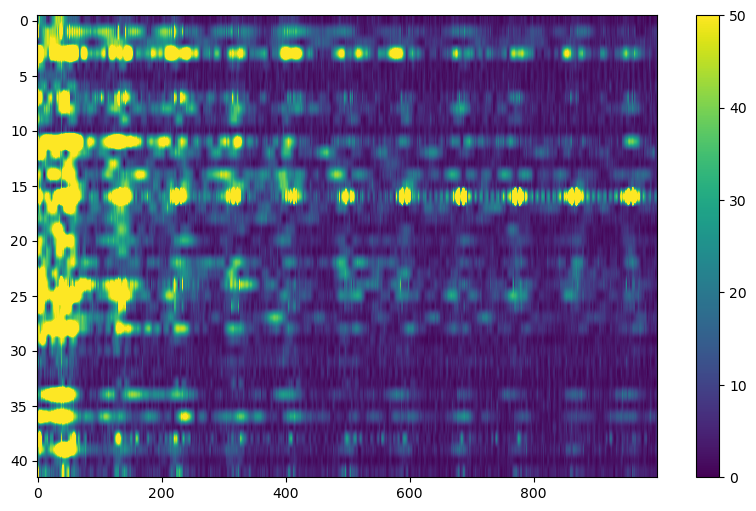

In [155]:
plt.figure(figsize=(10,6))
plt.imshow(x_fft,aspect='auto',vmin=0,vmax=50)
plt.colorbar()
#plt.xlim(0,100)
plt.show()

# 

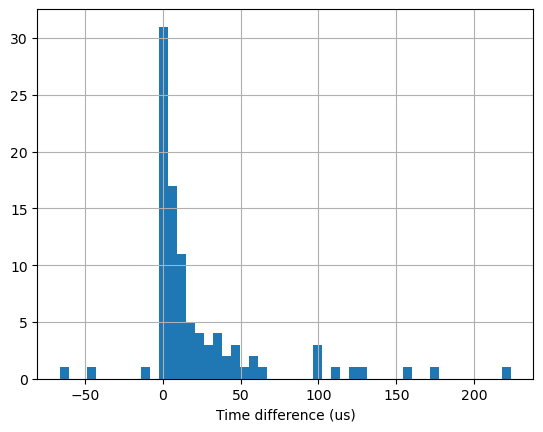

In [49]:
diff=np.array(exceed_y)-np.array(exceed_x)
diff[(exceed_x==0)&(exceed_y==0)]=np.nan
diff=diff[~np.isnan(diff)]
diff=diff[diff<300]



plt.hist(diff,bins=50)
#plt.xlim(-100,200)
plt.xlabel('Time difference (us)')
plt.grid()
plt.savefig('HV_timediff.png',dpi=100)
plt.show()

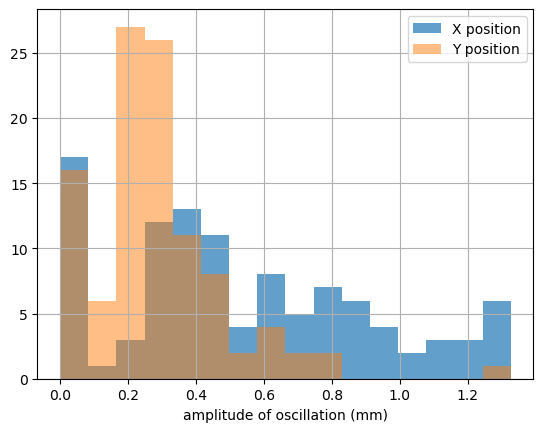

In [11]:
shinpuku_x[(exceed_x==0)&(exceed_y==0)]=np.nan
shinpuku_y[(exceed_x==0)&(exceed_y==0)]=np.nan
plt.hist(np.array(shinpuku_x)*16.58/5,bins=16,label='X position',alpha=0.7)
plt.hist(np.array(shinpuku_y)*16.58/5,bins=16,label='Y position',alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('amplitude of oscillation (mm)')
plt.savefig('amplitude.png',dpi=100)
plt.show()

In [4]:
len(time_axis)

182

In [5]:
len(spectrum)

182

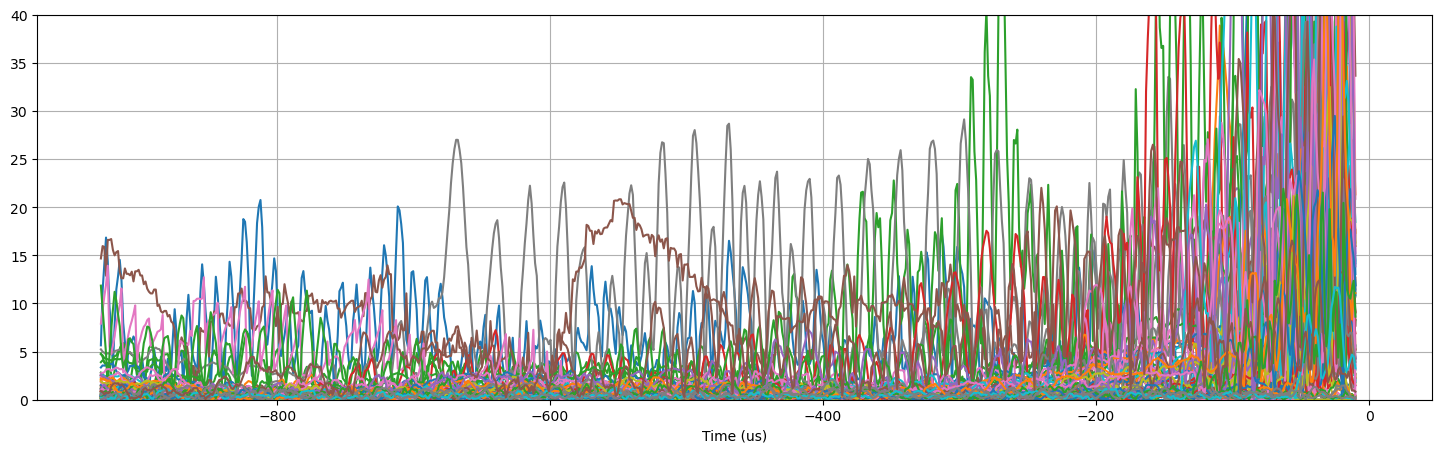

In [6]:
plt.figure(figsize=(18,5))
for i in range(len(time_axis)):
    if np.mean(spectrum[i][0:100])>10:
        continue
    plt.plot(time_axis[i],spectrum[i])
plt.ylim(0,40)
plt.xlabel('Time (us)')
plt.grid()
plt.savefig('abort_spectrum_normalabort.png',dpi=100)
plt.show()

# Clean up only X

In [45]:
def make_spectrum(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']


    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        return
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        return
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))
    


    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, 0, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=1)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除

    window_size = 640
    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return
    fftdata=df['result_interp'].iloc[len(df)-5120*turn:len(df)].values
    zeros=np.zeros(window_size//2)
    fftdata=np.concatenate([zeros,fftdata,zeros])
    # サンプリング周波数
    Fs = 509
    # データの準備
    data = fftdata
    x = np.arange(len(data))/509
    # FFT結果を保存するリスト
    fft_results = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]
        # FFTの計算
        fft_window=fft(window_data)
        fft_result = np.abs(fft_window)[313]
        # FFT結果の保存
        fft_results.append(fft_result)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)
    
    fft_results=fft_results.reshape(turn,int(5120/step_size))
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(1,5120,0,-1*turn))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Bunch inddex')
    plt.ylabel('Time [us]')
    plt.title('Time-varying FFT Heatmap Xpos')
    plt.savefig(f'abort_picture_2/{filename[8:-4]}_fftheatmap_bunch.png',dpi=100)
    plt.close()
    
    #------------------
    signal = df['result_interp'].values
    signal=signal[~np.isnan(signal)]
    if len(signal)==0:
        return 0,0,0,0,[0],[0]
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_fft = np.abs(fft_result[:len(fft_result)//2])
    #-------------------
    df=df.dropna()

    if len(df)==0:
        return 0,0,0,0,[0],[0]
    df['x']=df['x']-df['x'].iloc[-1]

    plt.figure(figsize=(16,3))
    plt.title(f'{filename}')
    plt.scatter(df['x'],df['result_diff']*16.58/5,label='X Position',c='red',s=1)
    plt.ylim(-0.8,0.8)
    plt.grid()
    plt.ylabel('X position (mm)')
    plt.legend()
    plt.savefig(f'abort_picture_2/{filename[8:-4]}.png',dpi=100)
    plt.close()
    #################

    ######################################

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqs, positive_fft)
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    #plt.xscale('log')
    plt.savefig(f'abort_picture_2/{filename[8:-4]}_fft.png',dpi=100)
    plt.close()




   # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signal
    x = np.arange(len(data))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('tukey', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    fft_results_phase=[]
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]#* window
        # FFTの計算
        fft_window=fft(window_data)
        fft_result = np.abs(fft_window)[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウのsaishuu時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)

    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')
    plt.savefig(f'abort_picture_2/{filename[8:-4]}_fftheatmapx.png',dpi=100)
    plt.close()

    plt.figure(figsize=(16, 6))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')
    #plt.ylim(254,244)
    plt.savefig(f'abort_picture_2/{filename[8:-4]}_fftheatmapx_expanded.png',dpi=100)
    plt.close()

    
    time_axis=window_times-window_times[-1]-10/8
    spectrum=fft_results.T[2508]
    spectrum2=fft_results.T[0]
    plt.figure(figsize=(14,4))
    plt.plot(time_axis,spectrum,'o-',label='249.3MHz')
    plt.plot(time_axis,spectrum2,'o-',label='0MHz')
    plt.ylim(0,20)
    plt.grid()
    plt.xlabel('Time (us)')
    plt.legend()
    plt.savefig(f'abort_picture_2/{filename[8:-4]}_amplitude_suii.png',dpi=100)
    plt.close()
    

   

In [77]:
make_spectrum("LERFUJI_2024-10-21_08-08-53.npz")

In [46]:
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'):
    print(i)
    make_spectrum(i)

LERFUJI_2024-10-22_06-38-26.npz
LERFUJI_2024-10-19_01-22-42.npz
LERFUJI_2024-10-17_01-05-01.npz
LERFUJI_2024-10-22_15-14-57.npz
LERFUJI_2024-10-10_22-11-36.npz
LERFUJI_2024-10-22_03-20-25.npz
LERFUJI_2024-10-21_22-10-13.npz
LERFUJI_2024-10-15_11-30-38.npz
LERFUJI_2024-10-10_21-29-54.npz
LERFUJI_2024-10-21_21-15-49.npz
LERFUJI_2024-10-21_07-54-25.npz
LERFUJI_2024-10-22_11-57-54.npz
LERFUJI_2024-10-20_11-00-25.npz
LERFUJI_2024-10-21_21-04-24.npz
LERFUJI_2024-10-13_11-42-07.npz
LERFUJI_2024-10-22_12-04-43.npz
LERFUJI_2024-10-17_09-02-58.npz
LERFUJI_2024-10-21_23-02-15.npz
LERFUJI_2024-10-21_21-02-19.npz
LERFUJI_2024-10-13_12-47-29.npz
LERFUJI_2024-10-18_10-04-59.npz
LERFUJI_2024-10-20_03-10-50.npz
LERFUJI_2024-10-22_03-00-16.npz
LERFUJI_2024-10-16_01-06-09.npz
LERFUJI_2024-10-21_21-19-37.npz
LERFUJI_2024-10-21_22-27-27.npz
LERFUJI_2024-10-21_22-28-41.npz
LERFUJI_2024-10-19_09-30-04.npz
LERFUJI_2024-10-14_00-14-04.npz
LERFUJI_2024-10-15_21-28-08.npz
LERFUJI_2024-10-20_13-51-29.npz
LERFUJI_

# Periodoc

In [137]:
def make_mastdplot(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Periodic/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']
    X_pos=npz_kw['X_Pos']
    X_ma=npz_kw['X_MA']
    X_std=npz_kw['X_STD']
    #X_valid=npz_kw['X_valid']
    Y_pos=npz_kw['Y_Pos']
    Y_ma=npz_kw['Y_MA']
    Y_std=npz_kw['Y_STD']
    #Y_valid=npz_kw['Y_valid']
    #iv=npz_kw['Injection_Veto']
    abortflag=npz_kw['AbortFlag']


    timesteps=np.arange(len(X_pos))/254.5
    timesteps=timesteps-timesteps[-1]

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result_x'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_x'] = df['result_x'] - df['result_x'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_x'] = np.where(abs(df['result_diff_x']) > 0.2, 0, df['result_diff_x'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=1)

    df['result_y'] = np.where(df['X_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_y'] = df['result_y'] - df['result_y'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_y'] = np.where(abs(df['result_diff_y']) > 0.2, 0, df['result_diff_y'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=1)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除



    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return [np.nan],[np.nan]
    tbtdata_111_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values

    
    #------------------
    signal=tbtdata_111_x[-5120*70:]
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_fft = np.abs(fft_result[:len(fft_result)//2])
    signal=tbtdata_111_y[-5120*70:]
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqsy = fft_freqs[:len(fft_freqs)//2]
    positive_ffty = np.abs(fft_result[:len(fft_result)//2])
    #-------------------



    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,6))
    ax1.set_title(f'{filename}')
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.scatter(timeaxis,tbtdata_111_x,c='red',s=1)
    ax1.set_ylim(-0.2,0.2)
    ax1.grid()
    ax1.set_ylabel('X position (mm)')
    ax2.scatter(timeaxis,tbtdata_111_y,c='red',s=1)
    ax2.set_ylim(-0.2,0.2)
    ax2.grid()
    ax2.set_ylabel('Y position (mm)')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_pos.png',dpi=100)
    plt.close()
    

    ######################################

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqs[:400], positive_fft[:400])
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.yscale('log')
    #plt.xlim(0,1)
    #plt.xlim(248,250)
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fftx.png',dpi=100)
    plt.close()

    ######################################
    """
    signal=tbtdata_111_x[-5120*50:]
    t=np.arange(len(signal))/509
    emd = EMD()
    imfs = emd(signal)
    
    # 結果をプロット
    plt.figure(figsize=(10, 8))
    plt.subplot(len(imfs) + 1, 1, 1)
    plt.plot(t, signal, 'r')
    plt.title("Original Signal")
    
    for i, imf in enumerate(imfs):
        plt.subplot(len(imfs) + 1, 1, i + 2)
        plt.plot(t, imf, 'g')
        plt.title(f"IMF {i + 1}")
    
    plt.tight_layout()
    plt.show()
    """

    """
    tbt_x=tbtdata_111_x.reshape([turn,5120])
    tbt_x = tbt_x[:, tbt_x[0] != 0]
    tbt_x -= np.mean(tbt_x, axis=0)
    tbt_x /= np.std(tbt_x, axis=0)
    n_components=1
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(tbt_x)
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    for i, component in enumerate(principal_components.T):
        plt.subplot(len(principal_components.T), 1, i + 1)
        plt.plot(component)
        plt.title(f"Principal Component {i+1}")
    plt.tight_layout()
    plt.savefig(f'periodic_picture/{filename[8:-4]}_pcax_waveform.png',dpi=100)
    plt.close()

    
    # 結果のプロット
    plt.figure(figsize=(12, 8))
    # 主成分ごとの分散割合をプロット
    plt.subplot(2, 1, 1)
    plt.bar(range(1, n_components + 1), explained_variance * 100)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.title('Variance Explained by Each Principal Component')
    # 各主成分の波形をプロット
    plt.subplot(2, 1, 2)
    for i in range(n_components):
        plt.plot(principal_components[:, i], label=f'PC{i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Principal Components (Vibration Modes)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'periodic_picture/{filename[8:-4]}_pcax.png',dpi=100)
    plt.close()

    
    N2=len(principal_components)//2
    N3=N2-len(principal_components)
    t = np.arange(N3,N2)
    split = principal_components.T[0]
    # omegaの範囲を指定
    omega_values =np.linspace(0, 3.14, 1000)
    integral_results = []
    # omegaの値を少しずつ変えて数値積分を実行
    for omega in omega_values:
        integrand = split * np.exp(-1j * omega * t) * (1 + np.cos(np.pi*t/N2))
        integral = np.trapz(integrand, t)  # トラペゾイド則で数値積分
        integral_results.append(integral/2/N2)
    
    plt.figure(figsize=(10,6))
    plt.plot(omega_values/2/np.pi, np.abs(integral_results))
    plt.savefig(f'periodic_picture/{filename[8:-4]}_naffx.png',dpi=100)
    plt.close()
    

    
    tbt_y=tbtdata_111_y.reshape([turn,5120])
    tbt_y = tbt_y[:, tbt_y[0] != 0]
    tbt_y -= np.mean(tbt_y, axis=0)
    tbt_y /= np.std(tbt_y, axis=0)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(tbt_y)
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    for i, component in enumerate(principal_components.T):
        plt.subplot(len(principal_components.T), 1, i + 1)
        plt.plot(component)
        plt.title(f"Principal Component {i+1}")
    plt.tight_layout()
    plt.savefig(f'periodic_picture/{filename[8:-4]}_pcay_waveform.png',dpi=100)
    plt.close()
    
    # 結果のプロット
    plt.figure(figsize=(12, 8))
    # 主成分ごとの分散割合をプロット
    plt.subplot(2, 1, 1)
    plt.bar(range(1, n_components + 1), explained_variance * 100)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.title('Variance Explained by Each Principal Component')
    # 各主成分の波形をプロット
    plt.subplot(2, 1, 2)
    for i in range(n_components):
        plt.plot(principal_components[:, i], label=f'PC{i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Principal Components (Vibration Modes)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'periodic_picture/{filename[8:-4]}_pcay.png',dpi=100)
    plt.close()


    
    N2=len(principal_components)//2
    N3=N2-len(principal_components)
    t = np.arange(N3,N2)
    split = principal_components.T[0]
    # omegaの範囲を指定
    omega_values =np.linspace(0, 3.14, 1000)
    integral_results = []
    # omegaの値を少しずつ変えて数値積分を実行
    for omega in omega_values:
        integrand = split * np.exp(-1j * omega * t) * (1 + np.cos(np.pi*t/N2))
        integral = np.trapz(integrand, t)  # トラペゾイド則で数値積分
        integral_results.append(integral/2/N2)
    
    plt.figure(figsize=(10,6))
    plt.plot(omega_values/2/np.pi, np.abs(integral_results))
    plt.savefig(f'periodic_picture/{filename[8:-4]}_naffy.png',dpi=100)
    plt.close()
    """





    ######################################



    """
   # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signal
    x = np.arange(len(signal))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]#* window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)


    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Xpos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,50)
    # プロット表示
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fft3Dx.png',dpi=100)
    plt.close()

    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')

    plt.ylim(240,254)
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fftheatmapx.png',dpi=100)
    plt.close()

    time_axis=window_times-window_times[-1]-10
    spectrum=fft_results.T[2508]
    plt.figure(figsize=(14,3))
    plt.plot(time_axis,spectrum,'o-')
    plt.ylim(0,10)
    plt.grid()
    plt.xlabel('Time (us)')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_amplitude_suii.png',dpi=100)
    plt.close()


    """
    #print(fft_results)
    #plt.plot(fft_results.T[np.argmax(positive_fft[12:])+12])
    #plt.show()

    ######################################3

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqsy[:400], positive_ffty[:400])
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.yscale('log')
    #plt.xlim(0,1)
    plt.savefig(f'periodic_picture/{filename[8:-4]}_ffty.png',dpi=100)
    plt.close()

    
    """
    # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signaly
    x = np.arange(len(signaly))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]# * window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)

    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Ypos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,10)
    # プロット表示
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fft3Dy.png',dpi=100)
    plt.close()
    
    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Ypos')

    plt.savefig(f'periodic_picture/{filename[8:-4]}_fftheatmapy.png',dpi=100)
    plt.close()

    """
    return positive_fft[:900],positive_ffty[:900]

/tmp/ipykernel_378127/701160850.py:149: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


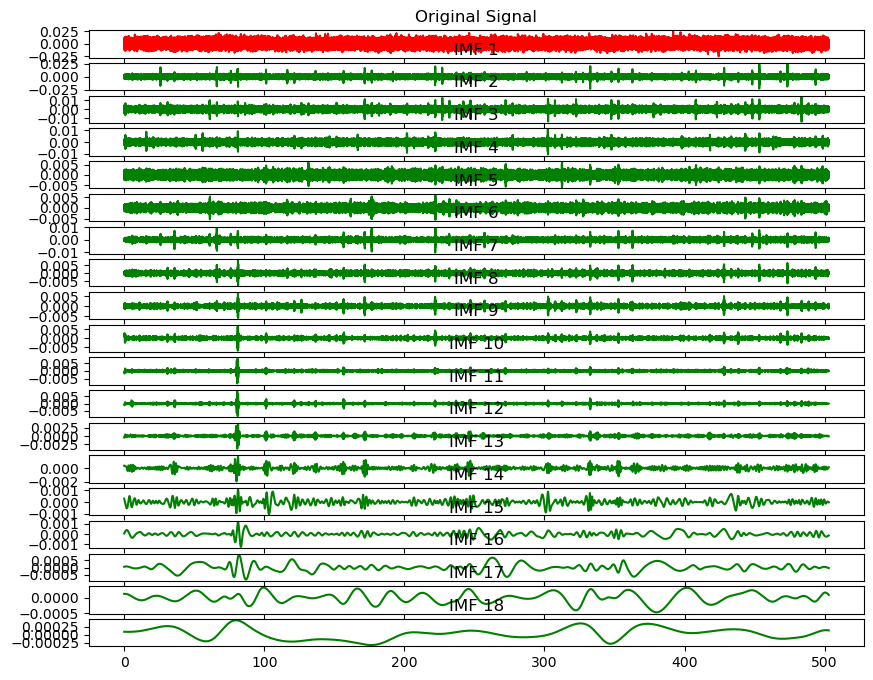

In [18]:
make_mastdplot("LERFUJI_2024-10-21_03-19-43.npz")

In [138]:
x_fft_p=[]
y_fft_p=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Periodic/'):
    a,b=make_mastdplot(i)
    if len(a)!=900:
        continue
    x_fft_p.append(a)
    y_fft_p.append(b)

x_fft_p=np.array(x_fft_p)
y_fft_p=np.array(y_fft_p)

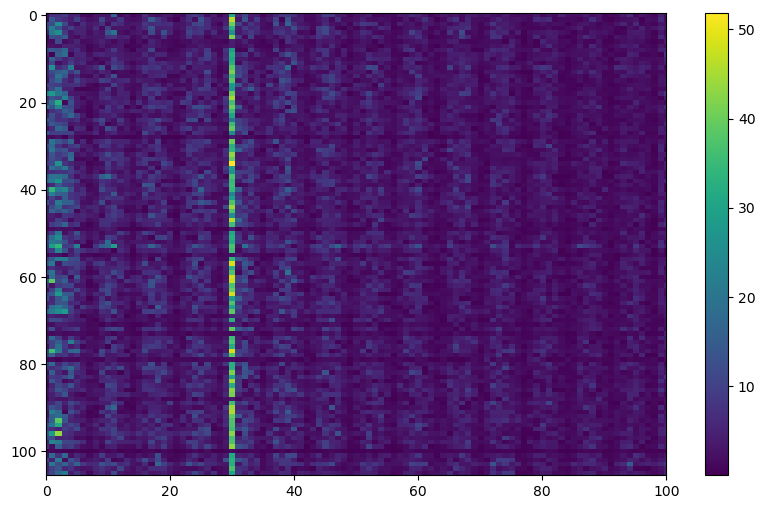

In [139]:
plt.figure(figsize=(10,6))
plt.imshow(x_fft_p,aspect='auto')
plt.colorbar()
plt.xlim(0,100)
plt.show()

In [16]:
with open('time_axis_periodic.pkl', 'wb') as f:
    pickle.dump(time_axis_periodic, f)
with open('spectrum_periodic.pkl', 'wb') as f:
    pickle.dump(spectrum_periodoc, f)

In [12]:
plt.figure(figsize=(18,5))
for i in range(len(time_axis_periodic)):
    plt.plot(time_axis_periodic[i],spectrum_periodoc[i])
plt.grid()
plt.ylim(0,20)
plt.savefig('periodoc_spectrum.png',dpi=100)
plt.show()
    

NameError: name 'time_axis_periodic' is not defined

<Figure size 1800x500 with 0 Axes>